In this notebook, I will be doing insight analytics on IMDb data set and implementing machine learning models to predict the average ratings. The notebook has been divided into the following sections:

1. Preprocessing & EDA
2. Modelling
3. Key Takeaways from the Analysis
4. Future Plan of Actions

## **1. Preprocessing & EDA**

In this section, I will read in relevant dataframes separately, perform explorative analysis, create new features as needed and then join them together. Below is a quick description of the preprocessing I have performed for each table. 



In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.regression import IsotonicRegression


spark = SparkSession.builder.appName('Audible').getOrCreate()


In [ ]:
df_ratings = spark.read.csv('/content/drive/MyDrive/Audible/data/title.ratings.tsv.gz', sep=r'\t', header=True,inferSchema=True)
df_name_basics = spark.read.csv('/content/drive/MyDrive/Audible/data/name.basics.tsv.gz', sep=r'\t', header=True,inferSchema=True)
df_title_basics = spark.read.csv('/content/drive/MyDrive/Audible/data/title.basics.tsv.gz', sep=r'\t', header=True,inferSchema=True)
df_crew = spark.read.csv('/content/drive/MyDrive/Audible/data/title.crew.tsv.gz', sep=r'\t', header=True,inferSchema=True)
df_episode = spark.read.csv('/content/drive/MyDrive/Audible/data/title.episode.tsv.gz', sep=r'\t', header=True,inferSchema=True)
df_principals = spark.read.csv('/content/drive/MyDrive/Audible/data/title.principals.tsv.gz', sep=r'\t', header=True,inferSchema=True)
#df_title_akas = spark.read.csv('/content/drive/MyDrive/Audible/data/title.akas.tsv.gz', sep=r'\t', header=True,inferSchema=True)

In [ ]:
prof_slc = df_name_basics.select('nconst','primaryName','birthYear','deathYear','knownForTitles',split('primaryProfession', ',').alias('primaryProfession'))
df_name_basics_m = prof_slc.select('nconst','primaryName','birthYear','deathYear','knownForTitles',
                                   *[prof_slc['primaryProfession'] [i] for i in range(3)])
df_name_basics_m.show(5)

+---------+---------------+---------+---------+--------------------+--------------------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|      knownForTitles|primaryProfession[0]|primaryProfession[1]|primaryProfession[2]|
+---------+---------------+---------+---------+--------------------+--------------------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|tt0053137,tt00319...|          soundtrack|               actor|       miscellaneous|
|nm0000002|  Lauren Bacall|     1924|     2014|tt0071877,tt00383...|             actress|          soundtrack|                null|
|nm0000003|Brigitte Bardot|     1934|       \N|tt0057345,tt00564...|             actress|          soundtrack|    music_department|
|nm0000004|   John Belushi|     1949|     1982|tt0072562,tt00804...|               actor|          soundtrack|              writer|
|nm0000005| Ingmar Bergman|     1918|     2007|tt0069467,tt00608...|        

For the **'title_basics'** table, I split the genre column, which stores the title's genre types, into three separate columns. Among all the titles, I found *drama, comedy, and talk-show* are the top three most common genres. During this take-home exercise, I assumed the order of genres listed for each title implies the descriptive power of this genre for this title. The first listed genre listed can better describe the title than the later genres.  Therefore, I only kept the first genres for the later one-hot encoding stage. But if time permits,  I will explore the model performance if we take in all genres listed for each title.  

For this table, I fill in the missing values in the 'endYear' column using the 'startYear' column's value unless the startYear is in the future. This is assumed we have filled in the endYear column for every title if it exists. All the cells left empty under the endYear column are intended when the titles were only released in a single year instead of being multi-year TV series. Therefore I choose to set the missing values in the endYear column the same as the startYear if missing. 

I also calculate two new features to describe the title: 'period' and  'yearSinceStart', which capture the title's time duration between the start and the end as well as how old is the title (assuming we are standing in the year of 2022). 




In [ ]:
genre_slc = df_title_basics.select('tconst','titleType','primaryTitle','originalTitle','isAdult',
                                  'startYear','endYear','runtimeMinutes',
                                  split('genres', ',').alias('genres'))

df_title_basics_m =  genre_slc.select('tconst','titleType','primaryTitle','originalTitle','isAdult',
                                  'startYear','endYear','runtimeMinutes',
                                   *[genre_slc ['genres'] [i] for i in range(3)])\
                                  .withColumn('startYear', col('startYear').cast(IntegerType()))\
                                  .withColumn('endYear', col('endYear').cast(IntegerType()))\
                                  .withColumn('period', col('endYear') - col('startYear'))\
                                  .withColumn('yearSinceStart', 2022 - col('startYear'))\
                                  .withColumn("endYear", \
              when(( col('endYear').isNull()) & (col('startYear')< 2022) ,col('startYear')).otherwise( col('endYear')))


In [ ]:
#count genres types across all three columns
genre0_count = df_title_basics_m.groupby('genres[0]').count().withColumnRenamed('genres[0]','genres')
genre1_count = df_title_basics_m.groupby('genres[1]').count().withColumnRenamed('genres[1]','genres')
genre2_count = df_title_basics_m.groupby('genres[2]').count().withColumnRenamed('genres[0]','genres')
all_genres = genre0_count.union(genre1_count).union(genre2_count).groupby('genres').sum('count').orderBy(desc('sum(count)')).withColumnRenamed('sum(count)', 'count').take(10)
all_genres

[Row(genres=None, count=12328798),
 Row(genres='Drama', count=2435948),
 Row(genres='Comedy', count=1782102),
 Row(genres='Talk-Show', count=1029019),
 Row(genres='Short', count=987449),
 Row(genres='Documentary', count=823354),
 Row(genres='Romance', count=779000),
 Row(genres='News', count=771302),
 Row(genres='Family', count=634415),
 Row(genres='Reality-TV', count=469603)]

After plotting out the distribution of titles' start years, I found the distribution has a long left tail and the majority of the titles are after 1950. Because our objective for this project is to predict the average rating for upcoming newly released titles (after 2022), older titles might be less insightful for our prediction.   I decided to cut off our training set's start year at 1950. 

In [ ]:
startYear_count = df_title_basics_m.groupby('startYear').count()\
                                    .select('startYear', col('count'))\
                                    .withColumn('dataset',when(col('startYear')>=2022,'test')\
                                    .when(col('startYear')<=2016,'train')
                                    .otherwise('validation'))\
                                    .sort(asc('startYear'))\
                                    .withColumn('startYear', col('startYear').cast(StringType()))

startYear_count = startYear_count.toPandas()

[Text(0.5, 1.0, 'Distribution of Titles')]

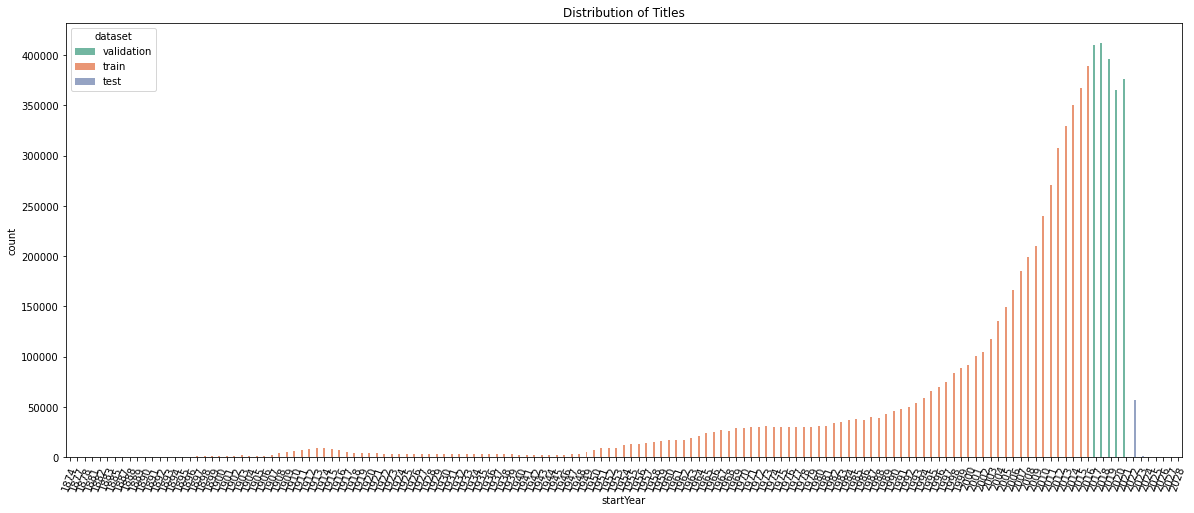

In [ ]:
plt.figure(figsize = (20,8))
plt.xticks(rotation=70)
sns.barplot( x=startYear_count['startYear'],y=startYear_count['count'], hue=startYear_count['dataset'],data=startYear_count, palette = 'Set2')\
          .set(title = 'Distribution of Titles')

 For the **crew** table, I split the title's directors and writers into separated columns. From the exploration analysis, I learned more than 75% of the titles only have one writer and one director listed. So I decided to only keep the first person listed for director and writer to avoid sparsity in the separated columns.

In [ ]:
split_d =  split(df_crew.directors, ',',)
split_w =  split(df_crew.writers, ',',)


df_crew_m = df_crew.withColumn('director[0]', split_d.getItem(0))\
    .withColumn('writer[0]', split_w.getItem(0)).drop('directors','writers')  


In [ ]:
df_episode_m = df_episode.withColumn('seasonNumber', df_episode['seasonNumber'].cast(IntegerType())) \
                         .withColumn('episodeNumber', df_episode['episodeNumber'].cast(IntegerType()))
                        

Due to the time and computation resource constrain, I decided not to include text-based features (e.g title name, crew name, etc.,) at this time. Instead, I try to use other features to represent the title and the production crew members. I come up with the following new features to serve the needs:

**Categorical(binary) Features:**

> Is the crew member participating in the production with his or her main profession? This column will be filled in as 0 if this is a title directed by an actor or is played by a writer. For the scope of scope of this project, I only focus on writers, actors and directors in the crew team.

> Is this title in this crew member's 'known for titles' list?

These two binary columns are first computed at the title-name level. Then I aggregated them to the title level by taking the average across all crew members for the given title.   

**Continuous Features:**


> For the lead director and the lead writer, how many titles have they participated in respectively? 

However, by looking at the summary statistcis, we can tell the experience level of the crew team is very widely spread and is skewed to the right. This intuitively makes sense given there different types of titles included in the IMDb's dataset. A long-lasting TV show's director will tend to have more experiences compared to a movie director based on our calculation. For future study, we could explore if we can assign different weights to different experience categories. For example, can we use models to learn weights of experience across different title types? Can we give higher weights for experienced directors practice directing under the same genre type? Can we standardize the experience counts for serries titles and non-serries titles?


To comply with the prediction task of this project, all of the additional features mentioned above are computed based on the training data, which are titles released between 1950 and 2016.  Only titles fit in this time range are counted towards the production crew members' professional qualifications. I compute the features using the training set data and join them back to the full data for validation and test set to use.    






In [ ]:
df_principals_m = df_principals.select('tconst','nconst','category')\
                                .filter(col('category').isin(['writer','director','actor']))

In [ ]:
full_data = df_ratings.join(df_title_basics_m, ['tconst'], 'inner')\
  .join(df_crew_m, ['tconst'],'left')\
  .join(df_episode_m, ['tconst'],'left')\
  .join(df_principals_m, ['tconst'],'left')
#join df_crew_m and df_principals_m to calculate # of experiences for directors and writers

train_data = full_data.filter((col('startYear')<=2016) & (col('startYear')>= 1950))


In [ ]:

#count professionalism for the crew team(writer + director + actors)
df_crewProf = df_principals_m.join(df_name_basics_m.select('nconst','knownForTitles','primaryProfession[0]'),                                   
                                   ['nconst'],'inner')
element_check = udf(lambda elt_list, elt: elt in elt_list)
df_crewProf  = df_crewProf.withColumn("isKnownFor",
                                     (element_check(df_crewProf.knownForTitles, df_crewProf.nconst)))\
                          .withColumn("isMainProf", (col("category")==col("primaryProfession[0]")).cast(IntegerType()))\
                          .withColumn('isKnownFor',when(col('isKnownFor') == 'false', 0).otherwise(1))\
                          .select('nconst','tconst','isKnownFor','isMainProf')
df_crewProf.show(5)

+---------+---------+----------+----------+
|   nconst|   tconst|isKnownFor|isMainProf|
+---------+---------+----------+----------+
|nm0000004|tt0076816|         0|         1|
|nm0000004|tt0077621|         0|         1|
|nm0000004|tt0077975|         0|         1|
|nm0000004|tt0078723|         0|         1|
|nm0000004|tt0079660|         0|         1|
+---------+---------+----------+----------+
only showing top 5 rows



In [ ]:
experience_train = train_data.select('nconst','tconst', 'category').filter(col('category').isin(['writer','director']))\
       .groupBy('nconst','category')\
       .pivot(
         'category',
         ['writer','director']) .count().na.fill(0)\
         .select('nconst',col('writer').alias('writer_exp'), col('director').alias('director_exp'))
experience_train.show(5)

+---------+----------+------------+
|   nconst|writer_exp|director_exp|
+---------+----------+------------+
|nm1704102|         1|           0|
|nm0524935|         5|           0|
|nm0621185|         0|           4|
|nm0465547|         0|           2|
|nm0755137|         1|           0|
+---------+----------+------------+
only showing top 5 rows



To understand how writers' and directors' experiences are distributed, I calculated the summary statistics are below: 

In [ ]:
experience_train.select('writer_exp').summary().show()

+-------+-----------------+
|summary|       writer_exp|
+-------+-----------------+
|  count|           332495|
|   mean|3.448866900254139|
| stddev|22.57988242389982|
|    min|                0|
|    25%|                0|
|    50%|                1|
|    75%|                1|
|    max|             2174|
+-------+-----------------+



In [ ]:
experience_train.select('director_exp').summary().show()

+-------+------------------+
|summary|      director_exp|
+-------+------------------+
|  count|            332495|
|   mean|2.3820779259838494|
| stddev|13.298538029099541|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|              2610|
+-------+------------------+



In [ ]:
#further clean-up the full data:
full_data_m = full_data.withColumn('isAdult', col('isAdult').cast(IntegerType()))\
         .withColumn('runtimeMinutes', col('runtimeMinutes').cast(IntegerType()))\
         .withColumn("isSerries", \
              when(full_data['parentTconst'].isNull(),0).otherwise(1))\
         .join(df_crewProf,['tconst','nconst'],'left')
        
full_data_m = full_data_m.alias('a').join(experience_train.drop('writer_exp').alias('b'),
                               col('a.director[0]') == col('b.nconst'),'left')\
                               .drop('b.ncost','a.nconst')\
                          .join(experience_train.drop('director_exp').withColumnRenamed('writer_exp[0]', 'writer_exp')\
                          .alias('c'),
                               col('a.writer[0]') == col('c.nconst'),
                               'left').drop('c.nconst')\
                          .select('tconst','a.nconst','averageRating','numVotes','titleType','isAdult',
                          'startYear','endYear','runtimeMinutes','genres[0]','period',
                          'yearSinceStart','seasonNumber','episodeNumber','isSerries','isMainProf','isKnownFor',
                          'director_exp','writer_exp')\
               .na.fill(0).groupby('tconst','averageRating','numVotes','titleType','isAdult',
                          'startYear','endYear','runtimeMinutes','genres[0]','period',
                          'yearSinceStart','seasonNumber','episodeNumber','isSerries',
                          'director_exp','writer_exp'
                          )\
                          .agg(sum('isMainProf').alias('isMainProf'),\
                               sum('isKnownFor').alias('isKnownFor')
                               ).drop('nconst')
full_data_m.show(5)


+---------+-------------+--------+---------+-------+---------+-------+--------------+-----------+------+--------------+------------+-------------+---------+------------+----------+----------+----------+
|   tconst|averageRating|numVotes|titleType|isAdult|startYear|endYear|runtimeMinutes|  genres[0]|period|yearSinceStart|seasonNumber|episodeNumber|isSerries|director_exp|writer_exp|isMainProf|isKnownFor|
+---------+-------------+--------+---------+-------+---------+-------+--------------+-----------+------+--------------+------------+-------------+---------+------------+----------+----------+----------+
|tt2798444|          7.8|       8|tvEpisode|      0|     1992|   1992|            59|Documentary|     0|            30|           1|            2|        1|           0|         0|         0|         0|
|tt1484444|          7.1|     853|tvEpisode|      0|     2009|   2009|            51|  Biography|     0|            13|           1|            2|        1|           0|         0|        

## **2. Modeling**

For this exercise,  my goal is to predict average ratings for newly released titles' ratings given the titles' and production crew's characteristics. Therefore, I choose to split the training, validation, and testing set by the title's production time (start year).  After exploring the cut-off years on the title destruction chart shown in the earlier section, I decide to split 1950 to 2016's titles into the training set, 2016-2021's titles into the validation set and treat titles after 2022 as training data.Among all the data, the training set takes 75% of the data, the validation set takes 24% of the data, and the testing set takes 1% of the data. 


In the modeling part, I implement linear model, random forest regression tree, and gradient-boosted regression tree on the training data.   Among all three models, the random forest has the smallest RMSE value on the validation set and the linear model has the biggest RMSE value. For the random forest model, I tried models with different numbers of trees and found random forest with nTree = 50 has slightly better RMSE. If given enough computation resources and time, I would like to do hyperparameter tuning for the random forest and further improve its prediction power. 

I also tried the embedded model by taking the average of predicted results from different models. But the embedded model didn't outperform other models in terms of validation RMSE value.

Based on the model performance on the validation set, I chose random forest with nTree = 50 to fit on the testing set (new titles after 2022) and achieve testing RMSE 1.45248. 

In [ ]:
train_data = full_data_m.filter((col('startYear')<=2016) & (col('startYear')>= 1950))
val_data = full_data_m.filter((col('startYear')>2016)&(col('startYear')<= 2021))
test_data = full_data_m.filter(col('startYear')>=2022)


In [ ]:
full_data_m.select('tconst','startYear').withColumn('dataset',when(col('startYear')>=2022,'test')\
                                    .when((col('startYear')<=2016)&(col('startYear')>=1950),'train').otherwise('validation'))\
                                    .groupby('dataset').count().show()

+----------+------+
|   dataset| count|
+----------+------+
|     train|914340|
|validation|299561|
|      test|  4287|
+----------+------+



In [ ]:
#fit one hot encoder to the categorical features(title types and genres)
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
#title types
title_indexer = StringIndexer(inputCol="titleType", outputCol="titleTypeIndex").setHandleInvalid("skip")
title_indexer_fited = title_indexer.fit(train_data)
train_data = title_indexer_fited.transform(train_data )
onehotencoder_title_vector = OneHotEncoder(inputCol="titleTypeIndex", outputCol="titleTypeIndex_vec")
onehot_fited_titleType = onehotencoder_title_vector.fit(train_data)
train_data = onehot_fited_titleType.transform(train_data)

#fit the same string indexer to validation and test data
val_data = title_indexer_fited.transform(val_data )
val_data = onehot_fited_titleType.transform(val_data)
test_data = title_indexer_fited.transform(test_data)
test_data = onehot_fited_titleType.transform(test_data)

#genres
genre_indexer = StringIndexer(inputCol="genres[0]", outputCol="genresIndex").setHandleInvalid("skip")
genre_indexer_fited = genre_indexer.fit(train_data)
train_data = genre_indexer_fited.transform(train_data )
onehot_fited_genre = OneHotEncoder(inputCol="genresIndex", outputCol="genresIndex_vec").fit(train_data)
train_data = onehot_fited_genre.transform(train_data)

#fit the same string indexer to validation and test data
val_data = genre_indexer_fited.transform(val_data )
val_data = onehot_fited_genre.transform(val_data)
test_data = genre_indexer_fited.transform(test_data)
test_data = onehot_fited_genre.transform(test_data)



In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["numVotes", "isAdult", "startYear", "endYear", "runtimeMinutes", "period", "yearSinceStart", "seasonNumber", "episodeNumber", "isSerries", "isMainProf", "isKnownFor",  "director_exp","writer_exp", "genresIndex_vec", "titleTypeIndex_vec"],outputCol="features")
train_data_final = assembler.transform(train_data)
# train_data_final.show(5)

In [ ]:
val_data_final = assembler.transform(val_data)
test_data_final = assembler.transform(test_data)


Linear regression:

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, featuresCol="features", labelCol="averageRating")
lrModel = lr.fit(train_data_final)


In [ ]:
#evaluate how the linear model fits on the training data:
trainingSummary = lrModel.summary
print("Linear model's training RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("Linear model's training r2: %f" % trainingSummary.r2)

RMSE: 1.251328
r2: 0.180739


In [ ]:
lrModel.coefficients

In [ ]:
lr_predict_val = lrModel.transform(val_data_final)
#lr_predict_val.select("prediction","averageRating","features").show(5)


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_rmse = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="averageRating",metricName="rmse")
print("Linear Regression RMSE on validation data = %g" % evaluator_rmse.evaluate(lr_predict_val))

Linear Regression RMSE on validation data = 1.33066


Random forest regression tree:

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
# Train a RandomForest model with default # of trees (20)
rf = RandomForestRegressor(featuresCol="features", labelCol="averageRating")
RFmodel = rf.fit(train_data_final)


In [ ]:
rf_predict_val = RFmodel.transform(val_data_final)
print("Randomforest RMSE on validation data = %g" % evaluator_rmse.evaluate(rf_predict_val))

Randomforest RMSE on validation data = 1.30627


In [ ]:
# Train a RandomForest model with default # of trees (50)
rf_50 = RandomForestRegressor(featuresCol="features", labelCol="averageRating",numTrees=50)
RFmodel_50 = rf_50.fit(train_data_final)
rf_50_predict_val = RFmodel_50 .transform(val_data_final)


In [ ]:
print("Randomforest(50 trees) RMSE on validation data = %g" % evaluator_rmse.evaluate(rf_50_predict_val))

Randomforest RMSE on validation data = 1.30523


In [ ]:
#get feature importance 
feature_df = pd.DataFrame( train_data_final.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
               train_data_final.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

feature_dict = dict(zip(feature_df["idx"],feature_df["name"])) 

feature_impt = [ (feature_dict[i], RFmodel_50.featureImportances[i]) for i, score in enumerate( RFmodel_50.featureImportances ) ]
feature_impt.sort( key = lambda x: x[1], reverse=True )


In [ ]:
rf_50_predict_test = RFmodel_50 .transform(test_data_final)
print("Randomforest RMSE on test data = %g" % evaluator_rmse.evaluate(rf_50_predict_test))

Randomforest RMSE on test data = 1.45248


Gradient-boosted regression tree:

In [ ]:
from pyspark.ml.regression import IsotonicRegression
gb = IsotonicRegression(featuresCol="features", labelCol="averageRating")
GBmodel = gb.fit(train_data_final)
gb_predict_val = GBmodel.transform(val_data_final)


In [ ]:
print("Gradient Boosting Model RMSE on validation data = %g" % evaluator_rmse.evaluate(gb_predict_val))

Gradient Boosting Model RMSE on validation data = 1.57145


Ensembles of prediction models

In [ ]:
#combine all three models together
pred_combine = rf_predict_val.select("prediction","averageRating","tconst").withColumnRenamed("prediction","prediction_lm").alias("lm")\
                .join(rf_50_predict_val.select("prediction","tconst").withColumnRenamed("prediction","prediction_rf").alias("rf"),['tconst'],'inner')\
                .join(gb_predict_val.select("prediction","tconst").withColumnRenamed("prediction","prediction_gb").alias("gb"),['tconst'],'inner')\
                .withColumn("prediction_ensemble",\
                           ((col("prediction_rf")+col("prediction_gb")+col("prediction_lm"))/3))\
                .withColumn('difference', (col('prediction_ensemble') - col('averageRating')))\
                .withColumn('squared_difference', pow(col('difference'), lit(2).astype(IntegerType())))
    
pred_ensamble_result = pred_combine.select(avg(col('squared_difference')).alias('rmse'))



In [ ]:
ensamble_rmse = pred_ensamble_result.withColumn('rmse',col('rmse').cast(StringType())).collect()[0][0]
print("Ensamble Model's RMSE on validation data = " + ensamble_rmse)

Ensamble Model's RMSE on validation data = 1.817107034689103


In [ ]:
#combine only the linear model and the random forest
pred_combine_2model = rf_predict_val.select("prediction","averageRating","tconst").withColumnRenamed("prediction","prediction_lm").alias("lm")\
                .join(rf_50_predict_val.select("prediction","tconst").withColumnRenamed("prediction","prediction_rf").alias("rf"),['tconst'],'inner')\
                .withColumn("prediction_ensemble",\
                           ((col("prediction_rf")+col("prediction_lm"))/2))\
                .withColumn('difference', (col('prediction_ensemble') - col('averageRating')))\
                .withColumn('squared_difference', pow(col('difference'), lit(2).astype(IntegerType())))
    
pred_ensamble_2model_result = pred_combine_2model.select(avg(col('squared_difference')).alias('rmse'))
ensamble_rmse_2model = pred_ensamble_2model_result.withColumn('rmse',col('rmse').cast(StringType())).collect()[0][0]
print("Ensamble Model (LR+RF) RMSE on validation data = " + ensamble_rmse_2model)

Ensamble Model (LR+RF) RMSE on validation data = 1.7128859149382427


### **3. Key Takeaways from the Analysis** 

In this take-home exercise, I tried to predict the title's average rating based on the objective characteristics of the title. Among all the features, title types, whether or not the title is part of the series show and the season number are the top three features in terms of prediction power returned by the random forest. This finding aligns with my intuition that a long-lived TV series can prove its popularity will also be favored by its audiences. 

Another important feature is the title categories. It has relatively stronger prediction potential for predicting the ratings. In the boxplot as below, we can see the 'TV episodes' has the highest median and the highest 25th percentile, implying this type of title may be easier to attract higher ratings.  


However, the current prediction model we have built still lacks prediction accuracy in terms of RMSE. Currently,  the features we have looked at are mainly objective characteristics. However,  the movie's rating can still be impacted by viewers' subjective opinions, which makes the prediction task harder. 



In [ ]:
feature_impt

[('titleTypeIndex_vec_tvEpisode', 0.19396219365088782),
 ('isSerries', 0.17000375499141746),
 ('seasonNumber', 0.1616411233245187),
 ('runtimeMinutes', 0.1150423435084644),
 ('titleTypeIndex_vec_movie', 0.09874345625363368),
 ('numVotes', 0.06674857577326944),
 ('genresIndex_vec_Documentary', 0.04975279648006684),
 ('episodeNumber', 0.02949227064065644),
 ('genresIndex_vec_Horror', 0.023916823444211685),
 ('isMainProf', 0.020397679528800082),
 ('writer_exp', 0.00904701501185535),
 ('startYear', 0.009021624735654725),
 ('yearSinceStart', 0.007521213859232455),
 ('titleTypeIndex_vec_tvSeries', 0.0061495326546987),
 ('titleTypeIndex_vec_short', 0.006130688886538877),
 ('genresIndex_vec_Game-Show', 0.004484363669657828),
 ('endYear', 0.004407425003511137),
 ('genresIndex_vec_Drama', 0.0034140336187145053),
 ('titleTypeIndex_vec_video', 0.003331393292806315),
 ('genresIndex_vec_Reality-TV', 0.002396348473674179),
 ('director_exp', 0.002351104984418445),
 ('genresIndex_vec_News', 0.002293229

[Text(0.5, 1.0, 'Title Categories VS Ratings')]

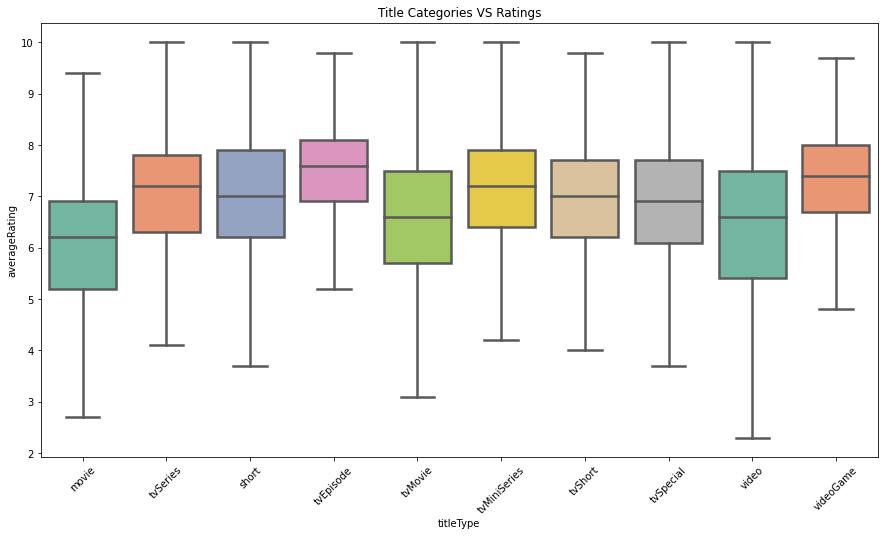

In [ ]:

plt.figure(figsize = (15,8))
plt.xticks(rotation=45)

sns.boxplot(data = train_data.select('averageRating','titleType').toPandas(),                                    
                                     y = 'averageRating', x = 'titleType', linewidth = 2.5 , palette = 'Set2', showfliers=False).set(title='Title Categories VS Ratings')



## **4. Future Plan of Actions**

While doing this take-home exercise, my intuitions about IMDb ratings got tested and new ideas were generated. Due to the limited time and computation resources I have, I cannot try out all the ideas I have in mind to predict average ratings. 

Here are some ideas worth trying if I would like to come back to improve this prediction exercise:



> 0. Perform more EDA to gather more insights and come up more feature ideas. Due to the big size of IMDb data and the slow response rate of the plotting functions, I couldn't do more visual analysis on the data and reveal the data relationships. 


> 1. Explore if we can find ways to standardize writers' and directors' experiences and make it a better feature in the prediction model. 



> 2. Try unsupervised learning methods on the movie genres. Maybe we can reduce the number of categories generated for the title genres by classifying genres into broader types. Therefore we can reduce the data sparsity after doing the one-hot encoding. 



> 3. Instead of training on the full historical data, we could try building submodels for subgroups of titles. The prediction can be made based on 'similar' historical titles. This requires us to explore how we can better measure similarities among titles. 



> 4. Explore text features (E.g: title names, crew member names) by using NLP techniques. 









